# SVR Model

In [153]:
# import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [154]:
USD = pd.read_csv('USD.csv')

In [155]:
USD.head()

,Date,Price,diff_1
0,2014-01-01,2.3650,NaN
1,2014-01-02,2.3350,-0.0300
2,2014-01-03,2.3350,0.0000
3,2014-01-06,2.3650,0.0300
4,2014-01-07,2.3515,-0.0135


In [156]:
# remove null values
USD.dropna(inplace=True)
USD.head()

,Date,Price,diff_1
1,2014-01-02,2.3350,-0.0300
2,2014-01-03,2.3350,0.0000
3,2014-01-06,2.3650,0.0300
4,2014-01-07,2.3515,-0.0135
5,2014-01-08,2.3575,0.0060


### Data Preprocessing

In [90]:
# Changing data to supervised learning
# adding moving average indicators of 5,10,20,60, 120 weeks and lag_1 as indicators
# setting inputs values
USD_supervised = pd.DataFrame()
USD_supervised['MA5'] = USD['diff_1'].ewm(span=5).mean()
USD_supervised['MA10']= USD['diff_1'].ewm(span=10).mean()
USD_supervised['MA20']=USD['diff_1'].ewm(span=20).mean()
USD_supervised['MA60']=USD['diff_1'].ewm(span=60).mean()
USD_supervised['MA120']=USD['diff_1'].ewm(span=120).mean()
USD_supervised['t'] = USD['diff_1'].shift(1)
USD_supervised['t+1'] = USD['diff_1']

In [91]:

USD_supervised.head()

,MA5,MA10,MA20,MA60,MA120,t,t+1
1,-0.030000,-0.030000,-0.030000,-0.030000,-0.030000,NaN,-0.0300
2,-0.012000,-0.013500,-0.014250,-0.014750,-0.014875,-0.0300,0.0000
3,0.007895,0.003987,0.001998,0.000667,0.000333,0.0000,0.0300
4,-0.000992,-0.001774,-0.002476,-0.003054,-0.003212,0.0300,-0.0135
5,0.001692,0.000457,-0.000426,-0.001121,-0.001308,-0.0135,0.0060


In [92]:
# remove null rows
USD_supervised.dropna(inplace=True)
USD_supervised.head()

,MA5,MA10,MA20,MA60,MA120,t,t+1
2,-0.012000,-0.013500,-0.014250,-0.014750,-0.014875,-0.0300,0.0000
3,0.007895,0.003987,0.001998,0.000667,0.000333,0.0000,0.0300
4,-0.000992,-0.001774,-0.002476,-0.003054,-0.003212,0.0300,-0.0135
5,0.001692,0.000457,-0.000426,-0.001121,-0.001308,-0.0135,0.0060
6,0.014777,0.010079,0.007575,0.005864,0.005433,0.0060,0.0375


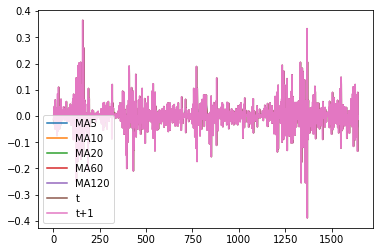

In [93]:
USD_supervised.plot()

In [94]:
USD_supervised.shape

(1641, 7)

In [95]:
#defining input(x) and output(Y) values    
# isolating X and Y columns
X = USD_supervised.iloc[:,:-1]
y = USD_supervised.iloc[:,-1]

# calculate train data size
train_size = int(len(USD_supervised)*0.8)
    
# split
X_train, y_train = X[0:train_size], y[0:train_size]
X_test, y_test = X[train_size:len(X)], y[train_size:len(y)]
    
#X_train,y_train,X_test,y_test

In [96]:
print('Length of train data :',train_size)
print('**************')
print('Length of test data :',len(USD_supervised)-train_size)

Length of train data : 1312
**************
Length of test data : 329


### SVR

In [74]:
# import packages
from sklearn.svm import SVR
from sklearn import metrics
from sklearn.metrics import accuracy_score

#### Metrics evaluation

In [75]:
def mean_absolute(actural_y,pred_y):
    return(metrics.mean_absolute_error(actural_y, pred_y))

In [76]:
def mean_squared(actural_y,pred_y):
    return(metrics.mean_squared_error(actural_y,pred_y))

In [77]:
def root_mean(actural_y,pred_y):
    return(np.sqrt(metrics.mean_squared_error(actural_y,pred_y)))

#### Invert difference

In [78]:
def invert_difference(orign_data, diff_data, interval):
    return[diff_data[i-interval]+orign_data[i-interval] for i in range(interval,len(orign_data))]

#### true y values

In [98]:
true_y = USD.iloc[train_size:,1].values
date = USD.iloc[train_size:,0].values

##### Linear Kernel 

In [114]:
svr_linear = pd.DataFrame({'C': [], 'epsilon': [], 'test-R2': [], 'train-R2': [], 'MAE': [], 'MSE': [], 'RMSE': []})
for C in [0.01,0.1,1,10,100]:
    for epsilon in [0.001,0.01,0.1]:
        linear_model = SVR(C=C,epsilon=epsilon,kernel='linear')
        
        #train
        linear_model.fit(X_train,y_train)
        
        #predict
        linear_pred = linear_model.predict(X_test)
        
        # Evaluate
        R2_score = linear_model.score(X_test,y_test)
        train_score = linear_model.score(X_train,y_train)
        MAE = mean_absolute(y_test,linear_pred)
        MSE = mean_squared(y_test,linear_pred)
        RMSE = root_mean(y_test,linear_pred)
        
        # form dataframe
        svr_linear = svr_linear.append({'C': C, 'epsilon': epsilon, 'test-R2': R2_score , 'train-R2': train_score ,'MAE': MAE, 'MSE': MSE, 'RMSE': RMSE}, ignore_index=True)
        
        # best predicted y values
        if R2_score == max(svr_linear['test-R2']):
            linear_pred = linear_pred

#Invert difference of best predicted y values
linear_pred_y = invert_difference(true_y, linear_pred, 1)

In [174]:
print(svr_linear.head(8))
print('\n'+'***************'+'\n')
print(svr_linear.tail(7))
print('\n'+'***************'+'\n')
print('Best linear score: \n')
best_linear_model = svr_linear[(svr_linear['test-R2']==max(svr_linear['test-R2']))]
print(best_linear_model)

      C  epsilon   test-R2  train-R2       MAE       MSE      RMSE
0  0.01    0.001  0.115467  0.101797  0.034903  0.003324  0.057653
1  0.01    0.010  0.122591  0.101386  0.034809  0.003297  0.057421
2  0.01    0.100  0.036851  0.029148  0.036414  0.003619  0.060161
3  0.10    0.001  0.582248  0.521323  0.024392  0.001570  0.039621
4  0.10    0.010  0.582168  0.516142  0.024417  0.001570  0.039625
5  0.10    0.100  0.234506  0.205869  0.032500  0.002877  0.053634
6  1.00    0.001  0.897516  0.838906  0.013178  0.000385  0.019624
7  1.00    0.010  0.886908  0.824358  0.013837  0.000425  0.020615

***************

        C  epsilon   test-R2  train-R2       MAE       MSE      RMSE
8     1.0    0.100  0.638986  0.547899  0.023806  0.001357  0.036832
9    10.0    0.001  0.946389  0.914633  0.009542  0.000201  0.014194
10   10.0    0.010  0.942204  0.906533  0.009985  0.000217  0.014737
11   10.0    0.100  0.841115  0.744938  0.016967  0.000597  0.024435
12  100.0    0.001  0.962740  0.94

In [116]:
# save output to latex table
with open('linear.tex','w') as tf:
    tf.write(svr_linear.to_latex())

#### Polynomial Kernel Function

In [118]:
svr_poly = pd.DataFrame({'C': [], 'epsilon': [], 'test-R2': [], 'train-R2': [], 'MAE': [], 'MSE': [], 'RMSE': []})
for C in [0.01,0.1,1,10,100]:
    for epsilon in [0.001,0.01,0.1]:
        poly_model = SVR(C=C,epsilon=epsilon,kernel='poly',degree=1)
            
        #train
        poly_model.fit(X_train,y_train)
        
        #predict
        poly_pred = poly_model.predict(X_test)
        
        # Evaluate
        R2_score = poly_model.score(X_test,y_test)
        tra_score = poly_model.score(X_train,y_train)
        MAE = mean_absolute(y_test,poly_pred)
        MSE = mean_squared(y_test,poly_pred)
        RMSE = root_mean(y_test,poly_pred)
        
        # form dataframe
        svr_poly = svr_poly.append({'C': C, 'epsilon': epsilon, 'test-R2': R2_score , 'train-R2': tra_score, 'MAE': MAE, 'MSE': MSE, 'RMSE': RMSE}, ignore_index=True)
            
        # best predicted y values
        if R2_score == max(svr_poly['test-R2']):
            poly_pred = poly_pred
                
#Invert difference of best predicted y values                
poly_pred_y = invert_difference(true_y, poly_pred, 1)

In [173]:
print(svr_poly.head(11))
print('\n'+'***************'+'\n')
print(svr_poly.tail(10))
print('\n'+'***************'+'\n')
print('Best Polynomial Score: \n')
best_poly_model = svr_poly[(svr_poly['test-R2']==max(svr_poly['test-R2']))]
print(best_poly_model)

        C  epsilon   test-R2  train-R2       MAE       MSE      RMSE
0    0.01    0.001  0.021346  0.018210  0.036707  0.003678  0.060643
1    0.01    0.010  0.021848  0.017966  0.036729  0.003676  0.060628
2    0.01    0.100  0.004930  0.003446  0.036997  0.003739  0.061150
3    0.10    0.001  0.179437  0.160140  0.033642  0.003084  0.055529
4    0.10    0.010  0.186015  0.159228  0.033542  0.003059  0.055306
5    0.10    0.100  0.055890  0.045632  0.036047  0.003548  0.059563
6    1.00    0.001  0.705382  0.635341  0.020847  0.001107  0.033273
7    1.00    0.010  0.694952  0.623532  0.021187  0.001146  0.033857
8    1.00    0.100  0.305595  0.283436  0.030992  0.002609  0.051083
9   10.00    0.001  0.915554  0.863621  0.012005  0.000317  0.017814
10  10.00    0.010  0.908114  0.853113  0.012578  0.000345  0.018582

***************

        C  epsilon   test-R2  train-R2       MAE       MSE      RMSE
5     0.1    0.100  0.055890  0.045632  0.036047  0.003548  0.059563
6     1.0    0.0

In [121]:
# save output to latex table
svr_poly = pd.DataFrame(svr_poly)
with open('poly.tex','w') as tf:
    tf.write(svr_poly.to_latex())

#### rbf kernel function

In [167]:
svr_rbf = pd.DataFrame({'C': [], 'epsilon': [], 'test-R2': [], 'train-R2': [], 'MAE': [], 'MSE': [], 'RMSE': []})
for C in [0.01,0.1,1,10,100]:
    for epsilon in [0.001,0.01,0.1]:
        rbf_model = SVR(C=C,epsilon=epsilon,kernel='rbf',gamma=1)
            
        #train
        rbf_model.fit(X_train,y_train)
        
        #predict
        rbf_pred = rbf_model.predict(X_test)
        
        # Evaluate
        R2_score = rbf_model.score(X_test,y_test)
        tra_score = rbf_model.score(X_train,y_train)
        MAE = mean_absolute(y_test,rbf_pred)
        MSE = mean_squared(y_test,rbf_pred)
        RMSE = root_mean(y_test,rbf_pred)
            
        # form dataframe
        svr_rbf = svr_rbf.append({'C': C, 'epsilon': epsilon, 'test-R2': R2_score , 'train-R2': tra_score, 'MAE': MAE, 'MSE': MSE, 'RMSE': RMSE}, ignore_index=True)
            
        # best predicted y values
        if R2_score == max(svr_rbf['test-R2']):
            rbf_pred = rbf_pred

#Invert difference of best predicted y values
rbf_pred_y = invert_difference(true_y, rbf_pred, 1)

In [172]:
print(svr_rbf.head(11))
print('\n'+'***************'+'\n')
print(svr_rbf.tail(10))
print('\n'+'***************'+'\n')
print('Best rbf score: \n')
best_rbf_model = svr_rbf[(svr_rbf['test-R2']==max(svr_rbf['test-R2']))]
print(best_rbf_model)

        C  epsilon   test-R2  train-R2       MAE       MSE      RMSE
0    0.01    0.001  0.201433  0.183319  0.033126  0.003001  0.054780
1    0.01    0.010  0.206711  0.181211  0.033051  0.002981  0.054599
2    0.01    0.100  0.064123  0.053826  0.035879  0.003517  0.059303
3    0.10    0.001  0.726944  0.664761  0.019956  0.001026  0.032033
4    0.10    0.010  0.713270  0.651345  0.020393  0.001077  0.032825
5    0.10    0.100  0.332924  0.313602  0.030287  0.002507  0.050067
6    1.00    0.001  0.915954  0.872977  0.011625  0.000316  0.017772
7    1.00    0.010  0.905066  0.861811  0.012327  0.000357  0.018888
8    1.00    0.100  0.733017  0.661501  0.019925  0.001003  0.031674
9   10.00    0.001  0.948308  0.928279  0.008958  0.000194  0.013937
10  10.00    0.010  0.945963  0.921009  0.009269  0.000203  0.014250

***************

        C  epsilon   test-R2  train-R2       MAE       MSE      RMSE
5     0.1    0.100  0.332924  0.313602  0.030287  0.002507  0.050067
6     1.0    0.0

In [169]:
# save output to latex table
svr_rbf = pd.DataFrame(svr_rbf)
with open('rbf.tex','w') as tf:
    tf.write(svr_rbf.to_latex())

#### Save predicted test data to file
Created a dataframe to save test data set of all three kernel functions 

In [170]:
# form data frame of predicted values
result= pd.DataFrame()

result['Date'] = date[1:]
result['true-y'] = true_y[1:]
result['linear'] = linear_pred_y
result['rbf'] = rbf_pred_y
result['poly'] = poly_pred_y

result.head()

,Date,true-y,linear,rbf,poly
0,2019-01-15,4.8954,4.905255,4.903148,4.900131
1,2019-01-16,4.9105,4.910180,4.908345,4.904472
2,2019-01-17,4.9025,4.903041,4.900754,4.899033
3,2019-01-18,4.9150,4.914668,4.912750,4.909246
4,2019-01-21,4.9112,4.910092,4.907825,4.906057


In [165]:
#set index
result.set_index('Date',inplace=True)
result.head()

,true-y,linear,rbf,poly
Date,,,,
2019-01-15,4.8954,4.905255,4.903148,4.900131
2019-01-16,4.9105,4.910180,4.908345,4.904472
2019-01-17,4.9025,4.903041,4.900754,4.899033
2019-01-18,4.9150,4.914668,4.912750,4.909246
2019-01-21,4.9112,4.910092,4.907825,4.906057


In [166]:
# we save the data result.csv to the file
result.to_csv('result.csv', sep=',')

### Save all three best score of the kernel function 

In [180]:
kernel_funct = pd.concat([best_linear_model,best_poly_model,best_rbf_model])

In [206]:
# rename index, remove C,epsilon
kernel_function = kernel_funct[['test-R2','MAE','MSE','RMSE']]
kernel_function.index = ['Linear','Poly','RBF']

In [207]:
# we save the data result.csv to the file
kernel_function.to_csv('kernel_function.csv', sep=',')

In [208]:
# save output to latex table
with open('kernel.tex','w') as tf:
    tf.write(kernel_function.to_latex())